# Height and Weight of Boys Ages 5-17 Across Japan

# Introduction

Every year across Japan, measurement sessions are required by the government to be held at elementary schools in every region from ages 5-17, measuring each child's height and weight. **Using this data, we will be predicting the age of the child based on given height and weight in boys. We will be splitting the dataset into a training and testing set to test the accuracy of the model of predicting the age from the testing data’s height and weight of boys 5-17 in Japan.** 

# Preliminary Exploratory Data Analysis

In [2]:
install.packages("janitor")
install.packages("cowplot")
library(tidyverse)
library(janitor)
library(repr)
library(tidymodels)
library(cowplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

#### 1. Demonstration that the data set `man.csv` can be read into R 

In [10]:
# the following way of reading data is allowed according to Anthony's announcement.
man_data <- read_csv("man.csv")
head(man_data)

Rows: 624 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): category
dbl (5): year, height_average, height_standard deviation, body weight _avera...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,category,height_average,height_standard deviation,body weight _average,body weight _standard deviation
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,national,111.0,4.87,19.3,2.79
5,Hokkaido,111.3,4.81,19.3,2.83
5,Aomori,111.8,4.87,19.9,2.78
5,Iwate,111.0,5.08,19.6,3.02
5,Miyagi,111.3,4.90,19.7,3.04
5,Akita,112.3,5.08,19.9,3.16


### 2. Data wrangling and cleaning 
1. We see that some of the column names contained space in between words, we will clean the column names using `clean_names` to make column name only contain lower case letters and underscores.
2. In the `category` column, which represents the region of each observation, we found that there is one category/region called "national", which is the average of the values for all regions in the category/region column. We remove all the observations with "national" in the `category` column.
3. remove the unused columns (variables): `category`, `height_standard_deviation`, `body_weight _standard_deviation`. 
4. change the column (variable) `year` to `age`.

The above steps have made sure the `clean_man_data` is currently in a tidy format. 

In [11]:
clean_man_data <- man_data |>
        clean_names() |>
        filter(category != "national") |>
        select(-category, -height_standard_deviation, -body_weight_standard_deviation) |>
        rename("age" = "year")
# take a look to make sure it looks good
head(clean_man_data)

age,height_average,body_weight_average
<dbl>,<dbl>,<dbl>
5,111.3,19.3
5,111.8,19.9
5,111.0,19.6
5,111.3,19.7
5,112.3,19.9
5,111.5,19.5


#### 3. Initial split of our data set `clean_man_data` (to training and testing data) 

In [12]:
set.seed(9999) # set.seed to make sure it is reproducible 

man_split <- initial_split(clean_man_data, prop = 0.75, starta = age)
man_train <- training(man_split)
man_test <- testing(man_split)

# take a look to make sure it looks good 
head(man_train)
head(man_test)

age,height_average,body_weight_average
<dbl>,<dbl>,<dbl>
7,123.3,25.8
10,138.8,34.8
9,133.6,32.0
11,146.1,40.0
7,122.3,24.3
6,116.6,21.3


age,height_average,body_weight_average
<dbl>,<dbl>,<dbl>
5,111.3,19.7
5,111.3,19.6
5,111.2,19.2
5,111.4,19.3
5,111.7,19.4
5,110.8,19.3


### 4. Preliminary summary tables of the training data 
1. We want to know the number of observations (rows) for each age from 5-17 in training set by creating the dataframe `number_observation_by_age`.
2. We want to get a summary of the predictors (weight and height). We create a dataframe that contains the means and standard deviations for the predictor variables called `summary_predictors`.
3. We want to know if there is any observation that contains missing values using `complete.cases`. We calculate the number of rows containing missing values `missing_rows` and found that there is **no missing value** in our training set.

In [13]:
number_obersvation_by_age  <- man_train |>
                    group_by(age) |>
                    summarize(count = n()) 

summary_predictors <- man_train |>
                pivot_longer(cols = height_average:body_weight_average,
                            names_to = "predictors", 
                            values_to = "value") |>
                group_by(predictors) |>
                summarize(mean = mean(value, na.rm = TRUE), 
                          SD = sd(value, na.rm = TRUE))
missing_rows <- man_train |>
                    filter(complete.cases(man_train) == FALSE) |>
                    nrow() 

In [14]:
number_obersvation_by_age
summary_predictors
missing_rows # here the missing_rows is 0 

age,count
<dbl>,<int>
5,35
6,36
7,38
8,34
9,38
10,34
11,34
12,38
13,37


predictors,mean,SD
<chr>,<dbl>,<dbl>
body_weight_average,40.6238,14.89841
height_average,144.6352,20.42834


[1] 0

### 5. Preliminary visualization of the training data 
1. We would like to visualize the distribution of the two predictors to get more information instead of the means and standard deviations from tables above. We create two histograms `height_plot` and `body_weight_plot` side by side to get more information about each predictor compare the shapes of them.  
2. Similar to the predictors, we would also like to know the distribution of the response variable `age` to see the number of observation for each age is comparable. We create the histogram of `age` called `age plot`. 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


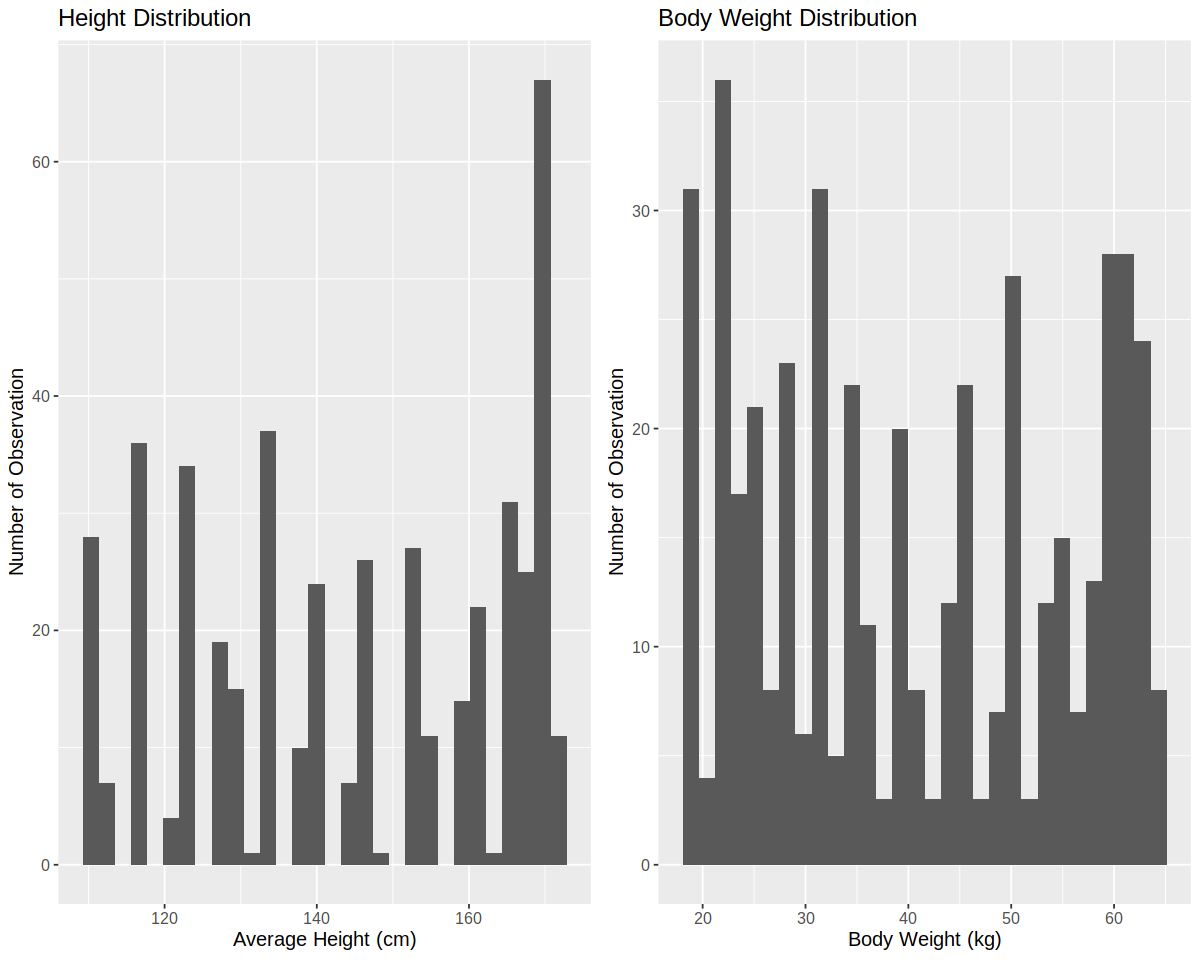

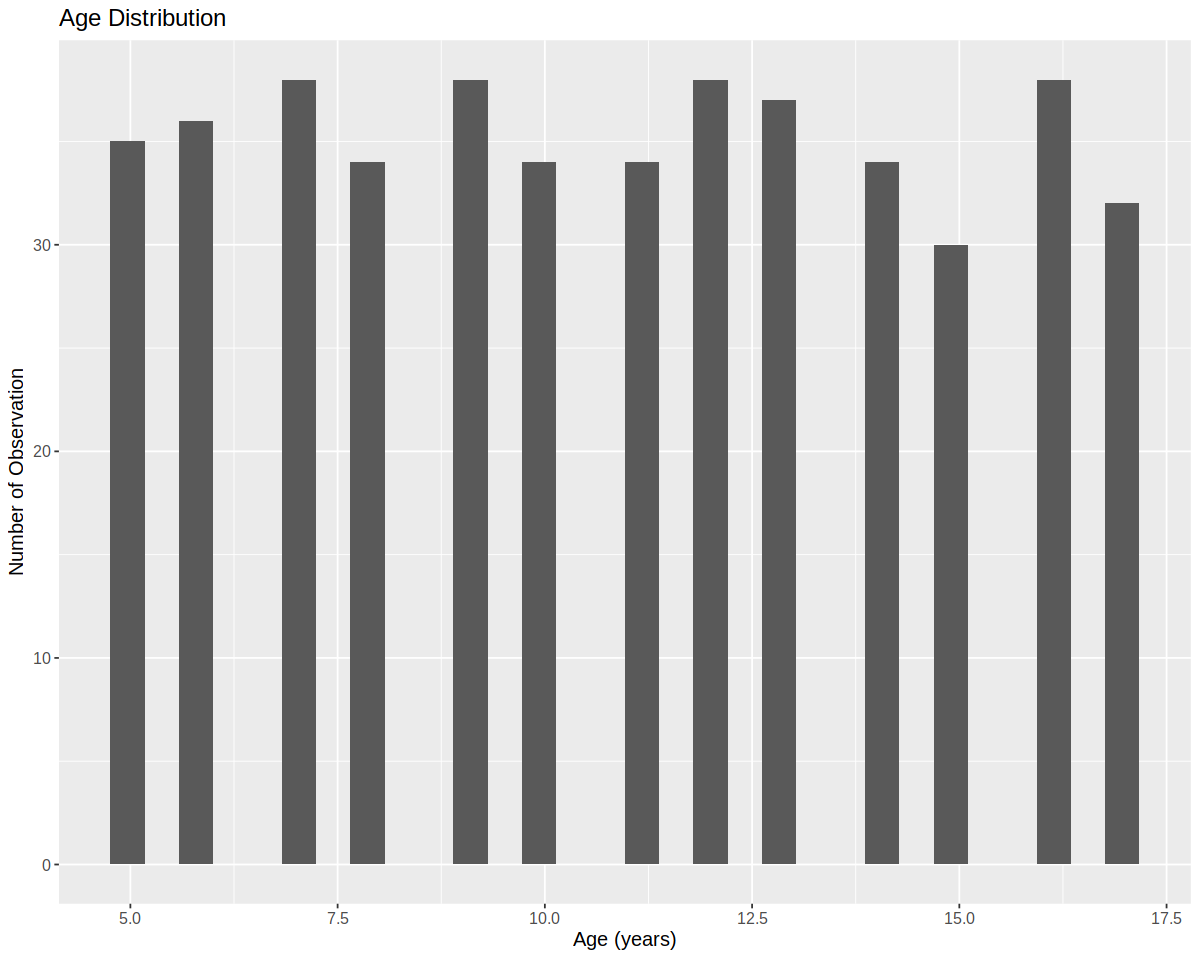

In [24]:
options(repr.plot.width = 10, repr.plot.height = 8)
# histograms for predictor variables. 
height_plot <- man_train |>
        ggplot(aes(x = height_average)) + 
            geom_histogram() + 
            labs(x = "Average Height (cm)", y = "Number of Observation") + 
            ggtitle("Height Distribution") + 
            theme(text = element_text(size = 12))


body_weight_plot <- man_train |>
        ggplot(aes(x = body_weight_average)) + 
            geom_histogram() + 
            labs(x = "Body Weight (kg)", y = "Number of Observation") + 
            ggtitle("Body Weight Distribution") + 
            theme(text = element_text(size = 12))

training_plot <- plot_grid(height_plot, body_weight_plot, nrow = 1)
training_plot

# histogram for response variable 
age_plot <- man_train |>
        ggplot(aes(x = age)) + 
            geom_histogram() + 
            labs(x = "Age (years)", y = "Number of Observation") + 
            ggtitle("Age Distribution") + 
            theme(text = element_text(size = 12))
age_plot # we see that the number of observation for each age is comparable 

# Methods

To conduct our analysis, we will read and clean our data, select the weight and height columns for prediction, perform cross-validation, and perform some form of regression to predict age. We will then visualize our results, likely using a scatterplot with a regression line superimposed.

# Expected Outcomes and Significance

By using the height and weight given for a Japanese boy, we can predict the child's age within the given range.

These findings could allow:
- Pediatric Healthcare providers to assess a (Japanese male) child's development and compare it to the average growth patterns as seen in this data set.
- Nutrition and dietary plans for this demographic. If a certain height to weight ratio in other countries produces an average age that differs from this data set.
- Physical Education programs to be tailored to the growth development 

For future questions, would this prediction set be similar for Japanese girls? Could it accurately predict their ages?  Maybe the prepubescent ages might have similar data?
